In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from ptsne.ptsne import ParametricTSNE

In [131]:
mnist_train = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [132]:
trainloader = torch.utils.data.DataLoader(mnist_train,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

trainloader_noshuffle = torch.utils.data.DataLoader(mnist_train,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

testloader = torch.utils.data.DataLoader(mnist_test,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [133]:
class Net(nn.Module):
    def __init__(self, use_cuda=True):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [99]:
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_altered(log_interval, model, device, altered_loader, embedding, optimizer, epoch, weight):
    model.train()
    for batch_idx, (data, target, label) in enumerate(altered_loader):
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        class_loss = torch.nn.CrossEntropyLoss()(output, label)
        embedding_loss = torch.nn.MSELoss()(embedding(output), target) / len(label)
        loss = (1 - weight) * class_loss + weight * embedding_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(altered_loader.dataset),
                100. * batch_idx / len(altered_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [134]:
net = Net()
#net = net.load_state_dict(torch.load('models/mnist-test-model.pt'))

In [135]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [136]:
for epoch in range(1, 3):
        # log run every epoch

        train(200, net, 'cuda', trainloader, optimizer, criterion, epoch)
        #test(net, 'cuda', testloader, criterion)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309252
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.634776
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.112696
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.173490
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.071197
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.110757
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.038343
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.032490
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.038107
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.013686
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.014412
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.133787


In [137]:
torch.save(net.state_dict(), 'models/mnist-test-model.pt')

In [138]:
with torch.no_grad():
    out = []
    for data, targets in trainloader_noshuffle:
        data = data.cuda()
        out.append(net(data))
outputs = torch.cat(out).cpu()

In [9]:
ptsne = ParametricTSNE(10, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)

In [10]:
#ptsne.fit(outputs, pretrain=True,verbose=True)
ptsne.fit(outputs[::12], pretrain=True, verbose=True)

Calculating PCA
2020-02-26 16:06:02.446762: Beginning pretraining for 5 epochs
2020-02-26 16:06:02.574418: Loss after epoch 0: 193.66768717765808
2020-02-26 16:06:02.687117: Loss after epoch 1: 28.37650203704834
2020-02-26 16:06:02.781865: Loss after epoch 2: 14.426454067230225
2020-02-26 16:06:02.880110: Loss after epoch 3: 5.706924319267273
2020-02-26 16:06:02.980871: Loss after epoch 4: 2.8653737753629684
2020-02-26 16:06:02.980871: Finished pretraining
Indexing
2020-02-26 16:06:29.431392: Beginning training for 10 epochs
2020-02-26 16:06:29.785581: Loss after epoch 1: 17.57746460618439
2020-02-26 16:06:30.149361: Loss after epoch 2: 16.251794355327707
2020-02-26 16:06:30.500437: Loss after epoch 3: 15.986653748543318
2020-02-26 16:06:30.864298: Loss after epoch 4: 15.550953576486865
2020-02-26 16:06:31.245044: Loss after epoch 5: 15.19418027170245
2020-02-26 16:06:31.608937: Loss after epoch 6: 15.060203477163757
2020-02-26 16:06:31.950744: Loss after epoch 7: 14.825285754604677
20

In [11]:
torch.save(ptsne, 'models/ptsne-test.pt')

In [12]:
ptsne.eval()

ParametricTSNE(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [139]:
projected = ptsne(outputs.cuda()).detach().cpu()

In [14]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

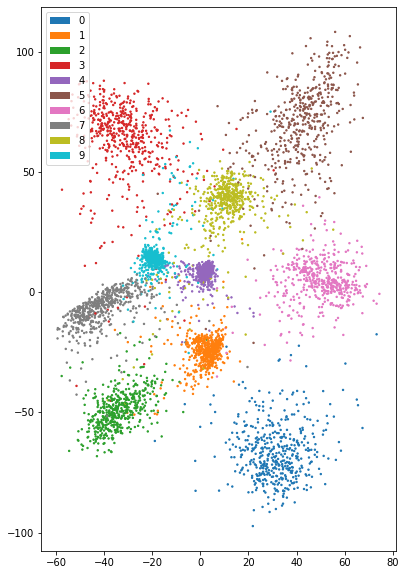

In [168]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(projected[::12,0], projected[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [33]:
push = (mnist_train.targets == 4).float().unsqueeze(1) * torch.tensor([8.,3.]) + (mnist_train.targets == 9).float().unsqueeze(1) * torch.tensor([0.,5.])
projected_pushed = projected + push

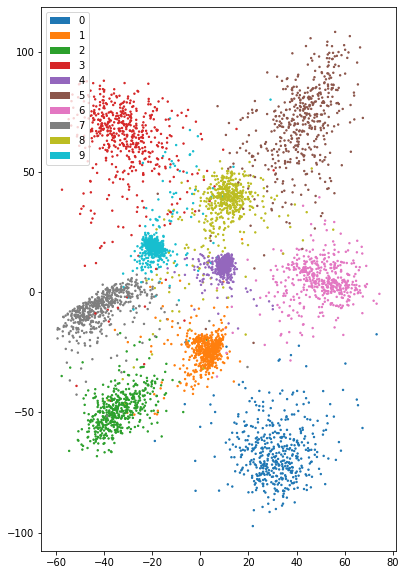

In [169]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(projected_pushed[::12,0], projected_pushed[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [153]:
with torch.no_grad():
    out = []
    for data, targets in trainloader_noshuffle:
        data = data.cuda()
        out.append(net(data).detach().cpu())
outputs = torch.cat(out)
projected = ptsne(outputs.cuda()).detach().cpu()

push = (mnist_train.targets == 4).float().unsqueeze(1) * torch.tensor([8.,3.]) + (mnist_train.targets == 9).float().unsqueeze(1) * torch.tensor([0.,5.])
projected_pushed = projected + push

pushdataset = torch.utils.data.TensorDataset(mnist_train.data.unsqueeze(1).float() / 255., projected_pushed, mnist_train.targets)
pushloader = torch.utils.data.DataLoader(pushdataset, batch_size=50, shuffle=True)
pushloader_noshuffle = torch.utils.data.DataLoader(pushdataset, batch_size=50, shuffle=False)

In [161]:
net = Net()
net.load_state_dict(torch.load('models/mnist-test-model.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(3):
    train_altered(200, net, 'cuda', pushloader, ptsne, optimizer, epoch, 1.)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.112600
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.751090
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.683125
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.301286
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.320340
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.311297
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.299529
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.134786
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.208857
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.167611
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.208593
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.117684
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.156836
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.128247
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.075871
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.139625
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.079203
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.130749


In [162]:
net.eval()
new_outputs = []
for data, target, label in pushloader_noshuffle:
    data = data.cuda()
    new_outputs.append(ptsne(net(data)).detach().cpu())

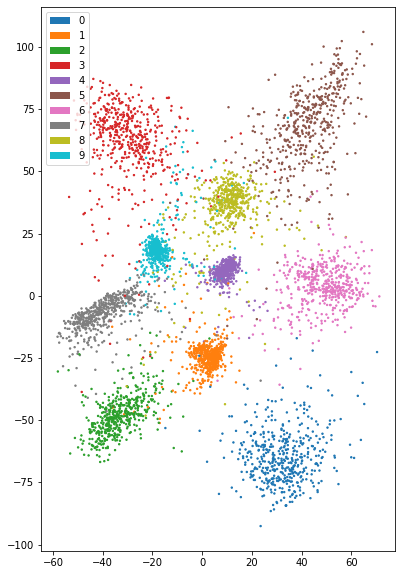

In [171]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(torch.cat(new_outputs)[::12,0], torch.cat(new_outputs)[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)